# Семинар 2. Текстовая регрессия

В этом семинаре нам предстоит решить задачу предсказания зарплаты по описанию вакансии.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Для начала скачиваем данные.

In [8]:
# !wget https://ysda-seminars.s3.eu-central-1.amazonaws.com/Train_rev1.zip
data = pd.read_csv("data/text_reg.csv", index_col=None)
data.shape

(244768, 12)

In [9]:
data.sample(5)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
161386,71189386,Estate Agent Senior Negotiator in Estate Agen...,Are you an experienced Estate Agent looking to...,"Trowbridge, Wiltshire Wiltshire South West",Trowbridge,NaN,permanent,AMR West of England,Sales Jobs,"From 18,000 to 23,000 per annum OTE",20500,totaljobs.com
140546,70577051,Customer Service,"If you are looking for a fasted paced, fun, cu...","Swansea, West Glamorgan",UK,NaN,contract,Workwales,Customer Services Jobs,7/hour,13440,cv-library.co.uk
137275,70408130,"Car Sales Executive, Leeds, Motor Trade Job","Automotive, Motor Trade Job: Experienced Sales...",Leeds,Leeds,NaN,NaN,Perfect Placement,Trade & Construction Jobs,12000 - 35000 per annum,23500,MyUkJobs
1101,46635605,Practice Nurse,Based in the City of London A Practice Nurse ...,"City Of London, London",The City,NaN,NaN,NaN,Healthcare & Nursing Jobs,33000 to 36000 per year,34500,careworx.co.uk
218935,72338909,CNC Machinist (Miller) weekend work,CNC (Miller) Machinist Based in Nottinghamshir...,"CNC Machinist - Nottinghamshire - 19-21,000 p/...",UK,NaN,permanent,ATA Recruitment,Other/General Jobs,19000 - 21000/annum + Holidays,20000,cv-library.co.uk


Первая проблема, с которой мы столкнемся - это распределение зарплат, близкое к экспоненциальному. Многие получают среднюю зарплату, но есть небольшая кучка людей с аномально высокой зарплатой. Как вы знаете из курса по машинному обучению, обучение модели на минимизацию MSE имеет смысл только тогда, когда таргеты распределены нормально. В противном случае стоит либо использовать другую функцию ошибки, либо как-то превести данные к нормальному распределению. Мы пойдем по второму пути и накинем логарифм на значения зарплат.

_Больше информации по этому вопросу в [описании соревнования](https://www.kaggle.com/c/job-salary-prediction#description)._

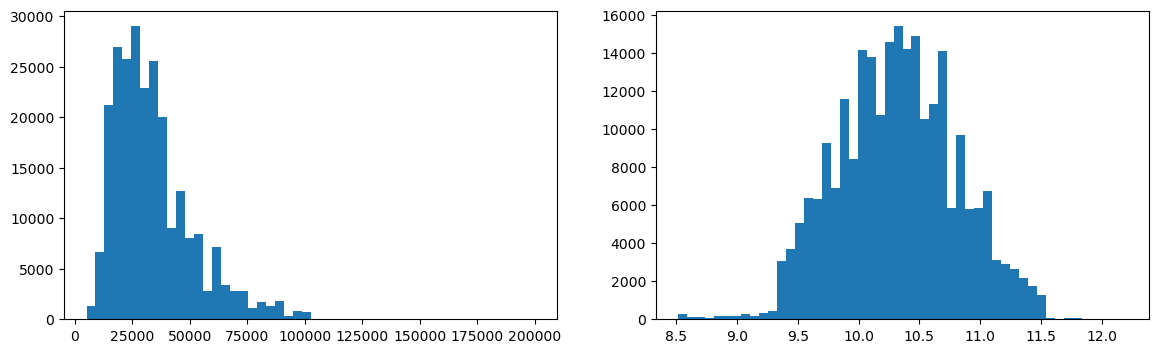

In [10]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[14, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=50);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=50);

Итак, наша задача - предсказать значение __Log1pSalary__.

Для этого мы можем извлечь признаки из
* текстовых данных: __`Title`__,  __`FullDescription`__
* категориальных данных: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, __`ContractTime`__

In [11]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
31475,68079175,Support Worker EAST****,30 hours per week Support workers required to ...,UK,UK,part_time,NaN,Mencap,Healthcare & Nursing Jobs,"14,176 Per Annum, Pro Rata. 30 Hours Per Week.",14176,totaljobs.com,9.559376
155536,71082874,TELEPHONE SALES,To apply please sent your CV to alexbaz****hot...,Chelmsford,Chelmsford,full_time,NaN,Envirosolar Ltd,Sales Jobs,"11,500 PER ANNUM BASIC OTE 18,000",14750,Jobcentre Plus,9.599066
125980,69994405,Project Engineer within the Body Engineering D...,Long term rolling contract UK Leading Automo...,Coventry West Midlands (County) West Midlands,UK,NaN,contract,Kelly Services,Engineering Jobs,From 20 to 23 per hour,41280,totaljobs.com,10.628158


### Начнем с текстовых данных

Как и в любой NLP задаче, сперва текст надо токенизировать. Сделаем это так же, как и на прошлом семинаре. Приведем текст к нижнему регистру, удалим всю пунктуацию и поделим на слова.

Для дальнейшего удобства лучше хранить каждый токенизированных текст в виде __одной строки со словами, разделенными пробелами__, а не списка, как было раньше.

In [12]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [13]:
import re

def tokenize(text):
    reg = re.compile(r'\w+')
    return reg.findall(text.lower())

In [14]:
%%time
data['Title'] = data['Title'].fillna('')
data["Title"] = data['Title'].map(lambda x: ' '.join(tokenize(x)))  # your code here
data["FullDescription"] = data["FullDescription"].map(lambda x: ' '.join(tokenize(x)))  # your code here

CPU times: total: 8.98 s
Wall time: 8.98 s


In [16]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller simulation analyst operation'
assert data["Title"][54321] == 'international digital account manager german'

Tokenized:
2         mathematical modeller simulation analyst opera...
100002    a successful and high achieving specialist sch...
200002    web designer html css javascript photoshop ill...
Name: FullDescription, dtype: object


Не все слова одинаково полезны. Некоторые из них встречаются очень редко, и поэтому модель не сможет выучить их значение. При этом эмбеддинги для таких слов к тому же будут занимать место в памяти, что плохо.

Давайте посчитаем, сколько раз встречалось каждое слово, и выкинем редкие.

In [17]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in both "Title" and "FullDescription" in total
# your code here
for text in data['Title']:
    token_counts.update(text.split())
for text in data["FullDescription"]:
    token_counts.update(text.split())

In [18]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 201697
('and', 2657388)
('the', 2080994)
('to', 2019884)
('a', 1521925)
('of', 1426213)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


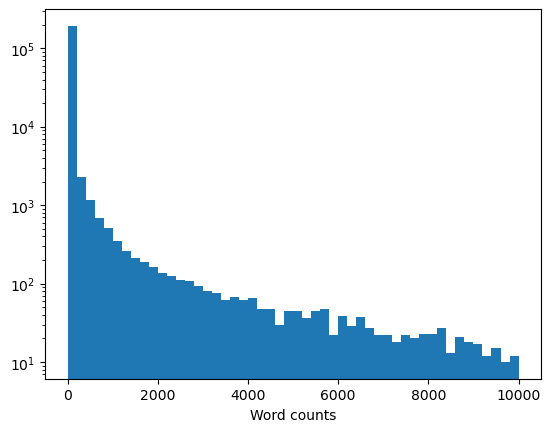

In [19]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts")
plt.show()

Создайте список уникальных токенов, которые встречались не меньше 10 раз, и отсортируйте их по частоте встречания.

In [20]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = sorted([(k, v) for k, v in token_counts.items() if v >= min_count], key=lambda x: -x[1])  # your code here
tokens, _ = zip(*tokens)
tokens = list(tokens)
# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [21]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 33816
Correct!


Создайте словарь _\{токен: индекс\}_ для всех токенов из списка.

In [22]:
token_to_id = {v: index for index, v in enumerate(tokens)}  # your code here

In [23]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


Эта функция кодирует набор текстов в виде матрицы из индексов токенов, добавляя паддинги к коротким текстам.

In [24]:
UNK_IDX, PAD_IDX = token_to_id[UNK], token_to_id[PAD]


def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = [x.split() for x in sequences]

    max_sequence_len = max([len(x) for x in sequences])
    if max_len is not None and max_len < max_sequence_len:
        max_sequence_len = max_len

    matrix = np.full((len(sequences), max_sequence_len), np.int32(PAD_IDX))
    for i, seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IDX) for word in seq[:max_sequence_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [25]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec i engineer

Matrix:
[[ 124  105  256    1]
 [ 297  223    1    1]
 [  91 4069  373   74]]


### Категориальные данные

Для кодирования категориальных признаков мы будем использовать one-hot-encoding. Это не лучшая идея в данном случае, так как различных значений у признаков много. Однако, реализацию более сложных методов мы оставим для вас.


In [26]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [27]:
data[categorical_columns].apply(dict, axis=1)[0]

{'Category': 'Engineering Jobs',
 'Company': 'Gregory Martin International',
 'LocationNormalized': 'Dorking',
 'ContractType': 'NaN',
 'ContractTime': 'permanent'}

### Обучение модели

Мы проделали все подготовительные шаги, а значит, самое время обучить нейронную сеть.

Стоит отметить, что мы немного схалтурили. Во-первых, мы не будем выделять валидационную выборку, так как не будем особо стараться улучшать модель. Во-вторых, для токенизации и сбора словаря мы использовали все данные, а не только тренировочные, как это надо делать. При желании, вы можете поправить эти неточности и посмотреть, как будет меняться результат.

In [28]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [30]:
import torch
import torch.nn as nn
import torch.functional as F


device = 'cuda' if torch.cuda.is_available() else 'cpu'


def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors


def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IDX, pad_ix=PAD_IDX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])


def make_batch(data, max_len=None, word_dropout=0, device=device):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IDX with this probability
    :returns: a dict with {
        'Title' : int64[batch, title_max_len],
        'FullDescription' : int64[batch, descr_max_len],
        'Categorical' : float32[batch, ohe_len],
        'Log1pSalary' : float32[batch]
    }
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))

    if word_dropout > 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)

    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values

    return to_tensors(batch, device)

In [31]:
make_batch(data_train[:3], max_len=10)

{'Title': tensor([[   91,    45,   695,     1,     1,     1],
         [ 2075,  3735,  5221,     7,  1367, 20789],
         [ 2866,    26,   332, 12149, 12825,     1]], device='cuda:0'),
 'FullDescription': tensor([[   91,    45,   695,  2668,     5,    91,    45,   695,    13,  2668],
         [ 2075,  3735,  5221,     7,  1367, 20789,   951,    64,  1982,    50],
         [    3,    52,   176,    36,    13,   156,   266,     5,    26,   332]],
        device='cuda:0'),
 'Categorical': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0'),
 'Log1pSalary': tensor([ 9.7115, 10.4631, 10.7144], device='cuda:0')}

#### Архитектура

Наша модель будет состоять из трех веток:
* Кодировщик заголовка
* Кодировщик описания
* Кодировщик категориальных признаков

Выходы всех трех веток будут конкатенироваться и затем преобразовываться в скаляр с помощью полносвязного слоя.

![scheme](https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png)

In [34]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super().__init__()
        # your code here
        self.embeding = nn.Embedding(n_tokens, hid_size)
        self.title_conv = nn.Conv1d(hid_size, hid_size, kernel_size=3)
        self.descr_conv = nn.Conv1d(hid_size, hid_size, kernel_size=3)

        self.cat_fc = nn.Linear(n_cat_features, hid_size)

        self.out_fc = nn.Linear(3*hid_size, 1)

    def forward(self, batch):
        # your code here
        #batch['Title']: [bs, seq_len]
        title_emb = self.embeding(batch['Title']) # [bs, seq_len, hid_size]
        desc_emb = self.embeding(batch['FullDescription'])

        title_emb = self.title_conv(title_emb.transpose(1, 2)) # [bs, hid_size, seq_len - 2]
        desc_emb = self.descr_conv(desc_emb.transpose(1, 2))

        title_emb = title_emb.mean(dim=2) # [bs, hid_size]
        desc_emb = desc_emb.mean(dim=2)

        cat_emb = self.cat_fc(batch['Categorical']) # [bs, hid_size]

        x = torch.hstack((title_emb, desc_emb, cat_emb)) # [bs, 3 * hid_size]
        
        return self.out_fc(x).squeeze()

In [35]:
model = SalaryPredictor().to(device)
batch = make_batch(data_train[:100])
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])
assert dummy_pred.shape == torch.Size([100])
assert len(torch.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

#### Обучение и валидация

Создадим функцию для бесконечной подачи батчей данных.

In [36]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=device):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device)
            yield batch

        if not cycle:
            break

Во время обучения мы будем логировать не только значение ошибки на валидации (зарплата у нас в логарифмической шкале, поэтому такую ошибку сложно интерпретировать), но и стандартное отклонение ошибки предсказания зарплаты в долларах.

In [37]:
from tqdm.auto import tqdm

BATCH_SIZE = 16
EPOCHS = 5

In [38]:
@torch.no_grad()
def print_metrics(model, data, batch_size=BATCH_SIZE, name='', device=torch.device('cpu')):
    squared_error = mse_exp_loss = num_samples = 0.0
    model.eval()

    mse_loss = nn.MSELoss(reduction='sum')

    for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, device=device):
        batch_pred = model(batch)
        squared_error += mse_loss(batch_pred, batch[TARGET_COLUMN]).item()
        mse_exp_loss += mse_loss(torch.expm1(batch_pred), torch.expm1(batch[TARGET_COLUMN])).item()
        num_samples += len(batch_pred)

    mse = squared_error / num_samples
    salary_pred_std = mse_exp_loss**0.5 / num_samples

    print(f'Mean square error: {round(mse, 4)}')
    print(f'Std of salary prediction error: {round(salary_pred_std, 4)}')

    return mse, salary_pred_std

### Обучение модели

Тут мы снова не будем слишком избирательны при выборе оптимизатора, расписания скорости обучения и гиперпараметров. Возьмем все самое простое, а при желании вы можете попробовать улучшить наш результат.

In [39]:
model = SalaryPredictor().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f'epoch: {epoch}')
    model.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print_metrics(model, data_val, device=device)

epoch: 0


  0%|          | 0/12238 [00:00<?, ?it/s]

Mean square error: 0.4946
Std of salary prediction error: 130.5568
epoch: 1


  0%|          | 0/12238 [00:00<?, ?it/s]

Mean square error: 0.2841
Std of salary prediction error: 89.9396
epoch: 2


  0%|          | 0/12238 [00:00<?, ?it/s]

Mean square error: 0.2381
Std of salary prediction error: 82.9549
epoch: 3


  0%|          | 0/12238 [00:00<?, ?it/s]

Mean square error: 0.2144
Std of salary prediction error: 79.0613
epoch: 4


  0%|          | 0/12238 [00:00<?, ?it/s]

Mean square error: 0.198
Std of salary prediction error: 76.1647


### Объяснение предсказаний

На практике очень полезно бывает уметь объяснять, почему модель выдала то или иное предсказание. Для простейших моделей (линейныя регрессия, дерево решений) возможность интерпретации встроена по умолчанию. Однако в случае нейронных сетей все не так просто, потому что зависимость предсказаний от признаков имеет очень сложную структуру, поэтому приходится придумывать всякие трюки.

Вот некоторые из способов посмотреть внутрь модели:
* Изменить вход и посмотреть, как меняется предсказание
* Поискать примеры, которые максимизируют или минимизируют активации конкретных нейронов (_больше об этом на [distill.pub](https://distill.pub/2018/building-blocks/)_)
* Построить локальную _линейую_ аппроксимацию модели: [LIME article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)
* Обучить нейронную сеть, сопоставляющую каждому слову его важность с точки зрения модели [L2X article](https://arxiv.org/abs/1802.07814)

В этом семинаре мы остановимся на первом способе, как на самом простом.

In [40]:
@torch.no_grad()
def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """

    baseline_pred = model(make_batch(sample, device=device)).cpu()
    sample = dict(sample.iloc[0])

    sample_col_tokens = [tokens[token_to_id.get(tok, 0)] for tok in sample[col_name].split()]
    data_drop_one_token = pd.DataFrame([sample] * (len(sample_col_tokens) + 1))

    for drop_i in range(len(sample_col_tokens)):
        data_drop_one_token.loc[drop_i, col_name] = ' '.join(UNK if i == drop_i else tok
                                                   for i, tok in enumerate(sample_col_tokens))

    predictions_drop_one_token = model(make_batch(data_drop_one_token, device=device)).cpu()
    diffs = baseline_pred - predictions_drop_one_token
    return list(zip(sample_col_tokens, diffs))

In [41]:
from IPython.display import HTML, display_html


def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):

    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(float(weight))), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]

    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]


    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))

    return raw_html


In [42]:
i = 36605
tokens_and_weights = explain(model, data.loc[i:i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i:i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

sales specialist iv access and infusion

sales representative medical sales iv access and infusion an opportunity to work for the industry leading manufacturer of iv access and infusion solutions formally recognised as the number company in this market space our client are an ethical and dynamic organisation absolutely committed to the advancement of innovative technologies job title sales specialist iv access and infusion selling medication delivery solutions selling to iv teams infection control lead intensive care nurse specialists ward managers territory east midlands location east midlands package basic k k uncapped bonus in addition full corporate benefits company information hugely ethical and professional global organisation extremely well established in the uk the market leader across all of their core business areas focus on providing cutting edge solutions along with outstanding service and support a business that retain talented personnel by offering a strong platform for career development sales specialist iv access and infusion you must have be the following at least 2 years medical device sales experience candidates who have sold disposables consumables or similar into hospitals would be of particular interest candidates must have sold into hospitals demonstrable performance and achievements so far personable adaptable and willing to learn keen and eager to be a success candidates must have a degree or at least be able to show a strong ability to learn role information managing the east midlands region selling across the company s range of iv and infusion solutions portfolio selling into lead intensive care nurse specialists ward managers iv teams infection control teams procurement sales specialist iv access and infusion candidates must be eligible to work and live in the uk please contact allan waller on or please hit the apply button this job was originally posted as www salestarget co uk jobseeking UNK

In [43]:
i = 12010
tokens_and_weights = explain(model, data.loc[i:i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i:i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

sales lead generation executive

company overview think methodology delivers a lead management and lead generation solution for some of the country s leading organisations that increases sales performance and uses datadriven intervention strategies to acquire retain and reactivate customers we deploy multichannel communications including email direct mail sms and online marketing campaigns to drive high value sales opportunities that have the highest propensity to convert role lead generation executive channel manager job purpose to develop relationships with our clients prospect base ultimately delivering high quality sales opportunities duties making outbound telephone calls on behalf of the client supported by email and direct mail campaigns produced by our inhouse creative team to generate appointments leads or attendees or to cleanse data records working with team leader to promote brand awareness so that every opportunity to meet the client needs is taken keep abreast of the latest market information so that you can promote the brand in the most accurate way ability to speak confidently and accurately to a varying degree of decision maker accurately take down and pass on details of prospect customers to the telemarketing team leader account manager to be sent through to the client keep a cleansed manageable and up to date database effectively and efficiently complete work allocated by team leader build good relationships with clients sales representatives and efficiently and effectively manage their time maintains relationships with clients by providing support information and guidance researching and recommending new opportunities recommending profit and service improvements prepares reports by collecting analysing and summarising information deal with inbound prospect customer queries and if appropriate resolve prospect customer complaints ensure the timely escalation of issues to the team leader as appropriate proactively pursue selfdevelopment opportunities within the agency contributes to team effort by accomplishing related results as needed assume joint responsibility for regularly reviewing performance and personal development discuss career aspirations and agree personal development plan with team leader in addition to the duties and responsibilities listed the job holder is required to perform other duties as assigned by their manager from time to time skills qualifications presentation skills client relationships emphasising excellence negotiation prospecting skills meeting sales goals creativity sales planning independence motivation for sales

In [44]:
i = np.random.randint(len(data))
print("Index:", i)
with torch.no_grad():
    print("Salary (gbp):", np.expm1(model(make_batch(data.iloc[i: i+1], device=device)).cpu()))

tokens_and_weights = explain(model, data.loc[i:i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i:i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Index: 103610
Salary (gbp): tensor(13913.7500)


tool setter injection moulding

you must have worked in this role for 2 years or more you will have a full driving license and ideally a forklift truck license as well as the ability to use power and hand tools you will be familiar with basic quality control principles s kaizen techniques and will be a clear communicator you will be able to change a moulding tool and be able to adjust injection moulding machines a rare opportunity to work within a closeknit team with great morale on the shop floor shift patterns apply and salary is negotiable depending on experience apply today

In [46]:
model

SalaryPredictor(
  (embeding): Embedding(33816, 64)
  (title_conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (descr_conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (cat_fc): Linear(in_features=3768, out_features=64, bias=True)
  (out_fc): Linear(in_features=192, out_features=1, bias=True)
)

In [48]:
model.out_fc.weight.data.cpu().shape

torch.Size([1, 192])